In [134]:
import pandas as pd
from obspy import read_events
import obspy
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from datetime import datetime
import ssl
from obspy import read
from obspy import Stream
from obspy import Trace
from obspy import UTCDateTime
#from geopy.distance import geodesic
from obspy.geodetics import gps2dist_azimuth
#import geopy
import numpy as np

#Inputs-----------------------
max_rad = 500
min_mag = 2.5
array  = 'HOM'
array2 = "KOD"

##Pull in data---------------------------
df = pd.read_csv('~/Downloads/Research/kodiak_homer_earthquakes.csv')
df = df.sort_values(by='Time_utc')
df = df.reset_index(drop = True)
df1 = df[df[array+'_distance(km)'] < max_rad].reset_index(drop=True)
df1 = df1[df1['Magnitude'] > min_mag].reset_index(drop=True)

### See what events were seen by both arrays-----------------------------
df = df[
    (df[array + '_distance(km)'] > max_rad) &
    (df[array2 + '_distance(km)'] < max_rad)].reset_index(drop=True)

df = df[df['Magnitude'] > min_mag].reset_index(drop=True)
print(len(df))
print(len(df1))

10
172


In [135]:
df.columns

Index(['Unnamed: 0', 'index', 'Name', 'Depth (km)', 'Magnitude', 'Latitude',
       'Longitude', 'Time_utc', 'Time_ak', 'KOD_distance(km)',
       'KOD_backazimuth', 'KOD_array', 'HOM_distance(km)', 'HOM_backazimuth',
       'HOM_array', 'array'],
      dtype='object')

ValueError: 'c' argument has 10 elements, which is inconsistent with 'x' and 'y' with size 172.

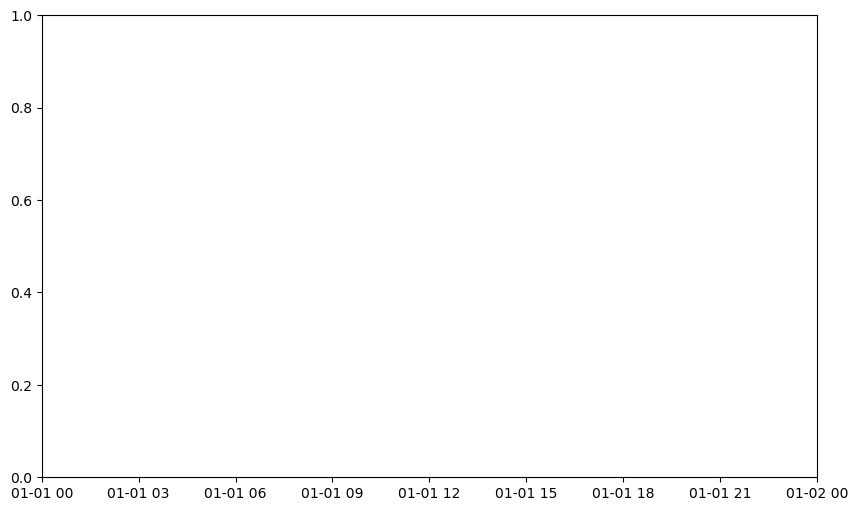

In [19]:
time_utc = df1['Time_utc'].to_numpy()
mag = df1['Magnitude'].to_numpy()
dist = df1['HOM_distance(km)'].to_numpy()
times_matplot = []
for i in range(len(time_utc)):
    wa = time_utc[i]
    times_matplot.append(dt.datetime(int(wa[0:4]),int(wa[5:7]), int(wa[8:10]), int(wa[11:13]),int(wa[14:16]),int(wa[17:19])))

fig, ax = plt.subplots(figsize = (10,6))
#sc = ax.scatter(times_matplot, mag, c= dist, cmap = 'plasma_r', vmin = 0, vmax = 500, s = 8*(1.8**mag), linewidth = 0.25, edgecolors = 'black')
#sc = ax.scatter(times_matplot, mag, c= 100*(np.array(stations_available)/26), cmap = 'magma', vmin = 0, vmax = 100, s = 10*(1.8**mag), linewidth = 0.25, edgecolors = 'black')
ax.scatter(times_matplot, mag, c= 100*(np.array(stations_available)/26), cmap = 'magma', vmin = 0, vmax = 100, s = 10*(1.8**mag), linewidth = 0.25, edgecolors = 'black')
fig.autofmt_xdate()
#ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
#ax.set_xlim(0, 10)
ax.set_ylim(0.5,6)
ax.set_ylabel('Earthquake magnitude (Ml)')
ax.set_xlim(pd.to_datetime("2025-09-07"),
            pd.to_datetime("2025-11-14"))
ax.grid(alpha = 0.3)
#plt.colorbar(sc, label = 'Percent of stations available')
#plt.savefig('data_availability_homer_earthquakes.png', transparent=True, dpi = 720)
plt.show()


In [171]:
import pandas as pd
from obspy import read_events
import obspy
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from datetime import datetime
import ssl
from obspy import read
from obspy import Stream
from obspy import Trace
from obspy import UTCDateTime
import numpy as np

from datetime import datetime, time, timezone
import datetime as dt
from obspy.taup import TauPyModel
from obspy.taup import taup_create

from obspy.geodetics import gps2dist_azimuth
from obspy.geodetics import kilometers2degrees

from obspy.taup import TauPyModel

from obspy.signal.util import util_geo_km

## FUNCTIONS##########################
##########################

def utc2datetime(utctime): #utc time as string
    return dt.datetime(int(utctime[0:4]),int(utctime[5:7]), int(utctime[8:10]), int(utctime[11:13]),int(utctime[14:16]),int(utctime[17:19]))
    
def is_between(check, start, end): #Returns true/false based on whether time is between two values
    return start <= check <= end

def pull_earthquakes(lat, lon, max_rad, start, end, min_mag, array_name, velocity_model):

    url = "https://earthquake.usgs.gov/fdsnws/event/1/query?format=quakeml&starttime="+start+"&endtime="+end+"&latitude="+lat+"&longitude="+lon+"&maxradiuskm="+max_rad+"&minmagnitude="+min_mag+""

    catalog = read_events(url)
    depths = []
    magnitudes = []
    latitudes = []
    longitudes = []
    times_utc = []
    times_ak = []
    names = []


# Extract data from each event
    for event in catalog:
    # Extract depth
        depth = event.origins[0].depth / 1000  # Depth is in meters, convert to kilometers
    
    # Extract magnitude
        magnitude = event.magnitudes[0].mag
    
    # Extract latitude and longitude
        latitude = event.origins[0].latitude
        longitude = event.origins[0].longitude
    
    # Extract time
        time = event.origins[0].time
    
        resource_id = event.resource_id.id
        name = resource_id.split('?')[-1]
        name = name[:-15]
        name= name[8:]
    
    # Append data to lists
        depths.append(depth)
        magnitudes.append(magnitude)
        latitudes.append(latitude)
        longitudes.append(longitude)
        times_utc.append(time)
        times_ak.append(time - 60*60*8)
        names.append(name)

# Create a DataFrame
    data = {
        'event_id': names,
        'depth': depths,
        'magnitude': magnitudes,
        'latitude': latitudes,
        'longitude': longitudes,
        'time_utc': times_utc,
        'time_ak': times_ak,
    }

    df = pd.DataFrame(data)
    sta_lat = float(lat)
    sta_lon = float(lon)

    dist = []
    baz = []
    array = []
    lats = df['latitude'].to_numpy()
    lons = df['longitude'].to_numpy()
    for i in range(len(df)):
        dist1, baz1, az = gps2dist_azimuth(lats[i], lons[i], sta_lat, sta_lon)
        dist.append(dist1/1000)
        baz.append(baz1)
        array.append(array_name)

    df['distance(km)'] = dist
    df['backazimuth'] = baz
    df['array'] = array
    
    ####ADD SLOWNESS DATA----------------------------
    slowness, trace_vel, incident_angle, p_arrival = calculate_slowness(dist,depths,velocity_model)

    df['slowness'] = dist
    df['trace_vel'] = baz
    df['incident_angle'] = incident_angle
    df['p_arrival'] = p_arrival
    
    HOM = df.reset_index(drop = True)
    return HOM

def calculate_slowness(distance_km, depth, velocity_model):
    mod = velocity_model #pavdut, iasp91, japan_1d, ak135, scak
    model = TauPyModel(model=mod)
    
    slowness = []
    trace_vel = []
    incident_angle = []
    p_arrival = []
    for i in range(len(distance_km)):
        dist_deg = kilometers2degrees(distance_km[i])

        #use 1d model to get incident angle/slowness
        arrivals_p = model.get_travel_times(source_depth_in_km=depth[i],
                                  distance_in_degree=dist_deg,
                                  phase_list = ["P","p"])
        arr = arrivals_p[0]
        ptime = arr.time
        p_arrival.append(ptime)
        angle = arr.incident_angle
        if mod == 'iasp91':
            vh = 5.8/(np.sin(np.deg2rad(angle))) #iasp91 surface velocity: 5.8
        elif mod == 'japan_1d':
            vh = 4.8/(np.sin(np.deg2rad(angle))) #japan_1D surface velocity: 5.8
        elif mod == 'ak135':
            vh = 5.8/(np.sin(np.deg2rad(angle)))
        elif mod == 'scak':
            vh = 5.3/(np.sin(np.deg2rad(angle)))
        else: #pavdut
            vh = 3.05/(np.sin(np.deg2rad(angle))) #pavdut surface velocity: 3.05

        slow = 1/vh
        slowness.append(slow)
        incident_angle.append(angle)
        trace_vel.append(vh)

    return slowness, trace_vel, incident_angle, p_arrival



def get_geometry(lat_list, lon_list, elev_list, return_center = False):
    nstat = len(lat_list)
    center_lat = 0.
    center_lon = 0.
    center_h = 0.
    geometry = np.empty((nstat, 3))

    for i in range(nstat):
        geometry[i, 0] = lon_list[i]
        geometry[i, 1] = lat_list[i]
        geometry[i, 2] = elev_list[i]

    center_lon = geometry[:, 0].mean()
    center_lat = geometry[:, 1].mean()
    center_h = geometry[:, 2].mean()
    for i in np.arange(nstat):
        x, y = util_geo_km(center_lon, center_lat, geometry[i, 0],
                               geometry[i, 1])
        geometry[i, 0] = x
        geometry[i, 1] = y
        geometry[i, 2] -= center_h

    if return_center:
        return np.c_[geometry.T,
                     np.array((center_lon, center_lat, center_h))].T
    else:
        return geometry
    


In [158]:
lat = '59.6184900' #HOM18
lon = '-151.1412100' #HOM18
#lat2 = '57.4423300' #KOD18
#lon2 = '-152.3516100' #KOD18
max_rad = '300'
start = str(np.min(start_d1_list))
end = str(np.max(end_d2_list))
min_mag = '2'
array_name = 'homer'
velocity_model = 'iasp91'
df = pull_earthquakes(lat, lon, max_rad, start, end, min_mag, array_name, velocity_model)

In [160]:
df.columns

Index(['event_id', 'depth', 'magnitude', 'latitude', 'longitude', 'time_utc',
       'time_ak', 'distance(km)', 'backazimuth', 'array', 'slowness',
       'trace_vel', 'incident_angle'],
      dtype='object')

In [169]:
output = get_geometry(lat_list, lon_list, elev_list, return_center = True)
origin_lat = output[-1][1]
origin_lon = output[-1][0]

In [170]:
origin_lat

57.442463230769235

In [180]:
from obspy import read_inventory

## INPUTS##########################
##########################
#Infor for pulling in inventory data

array = 'homer'
deployment = 'd1'

#Info for pulling in earthquakes
velocity_model = 'iasp91'
max_rad = '300'
min_mag = '2.5'

##########################
##########################

## READ IN INVENTORY FOR D1-------------------------
print("Pulling in data for "+array+" array")
path = '/Users/cadequigley/Downloads/Research/deployment_array_design/'
inv = read_inventory(path + array+'_'+deployment+'_station.xml')


## PULL INFORMATION OUT OF INVENTORY-------------------------
lat_list = []
lon_list = []
elev_list = []
station_d1_list = []
start_d1_list = []
end_d1_list = []
num_channels_d1_list = []

for network in inv:
    for station in network:
        lat_list.append(station.latitude)
        lon_list.append(station.longitude)
        station_d1_list.append(station.code)
        elev_list.append(station.elevation)
        start_d1_list.append(station.start_date)
        end_d1_list.append(station.end_date)
        num_channels_d1_list.append(station.total_number_of_channels)

## PULL IN DATA FOR SECOND DEPLOYMENT##########################
deployment = 'd2'

## READ IN INVENTORY FOR D2-------------------------
path = '/Users/cadequigley/Downloads/Research/deployment_array_design/'
inv = read_inventory(path + array+'_'+deployment+'_station.xml')


## PULL INFORMATION OUT OF INVENTORY-------------------------

start_d2_list = []
end_d2_list = []
station_d2_list = []
num_channels_d2_list = []

for network in inv:
    for station in network:

        start_d2_list.append(station.start_date)
        end_d2_list.append(station.end_date)
        num_channels_d2_list.append(station.total_number_of_channels)
        station_d2_list.append(station.code)

### Unique to Homer array, wouldn't apply to other arrays-----------------
if array =='homer':
    ## PULL IN BEAR DATA------------------
    bears = pd.read_csv('/Users/cadequigley/Downloads/Research/deployment_array_design/'+array+'_mseed_completeness.csv') #contains start/end times
    bears = bears[["station_name", "bear_removal_time_d1","bear_removal_time_d2"]]
    bear_time_d1 = bears['bear_removal_time_d1'].to_list()
    bear_time_d2 = bears['bear_removal_time_d2'].to_list()
    del bear_time_d2[5] #Removes HM06 since it doesn't have data in station xml for second deployment

#### Get center of array-------------------------------

output = get_geometry(lat_list, lon_list, elev_list, return_center = True)
origin_lat = str(output[-1][1])
origin_lon = str(output[-1][0])

### Pull in earthquakes-------------------------------
start = str(np.min(start_d1_list)) #time when first station online
end = str(np.max(end_d2_list)) #time when last station offline
array_name = array
df = pull_earthquakes(origin_lat, origin_lon, max_rad, start, end, min_mag, array_name, velocity_model)
print('Number of earthquakes >'+min_mag+' within '+max_rad+' km:', len(df))

Pulling in data for homer array
Number of earthquakes >2.5 within 300 km: 108


In [181]:
##SET UP DATA FOR CREATING STATION LISTS##

#Earthquakes------------------
earthquake_time = df['time_utc'].to_numpy()
earthquake_names = df['event_id'].to_numpy()

stations_lists = []
stations_available = []
for i in range(len(earthquake_names)): #setting up earthquakes to loop through
    eq_time = earthquake_time[i]
    eq_time = utc2datetime(str(eq_time))
    station_temp = []

    ### Check first deployment for station availability----------------------------
    for k in range(len(station_d1_list)):
        start_mseed = start_d1_list[k]
        start_mseed = utc2datetime(str(start_mseed))
        if array =='homer': #look at bear removal dates------------
            if bear_time_d1[k] == '0':
                end_mseed = end_d1_list[k]
                end_mseed = utc2datetime(str(end_mseed))
            else:
                end_mseed = bear_time_d1[k]
                end_mseed = utc2datetime(str(end_mseed))

        else: #kodiak array, doesn't have any nodes removed by bears
            end_mseed = end_d1_list[k]
            end_mseed = utc2datetime(str(end_mseed))
        
        #Find if station exists------------------------    
        x = is_between(eq_time, start_mseed, end_mseed)

        if x == True:
            station_temp.append(station_d1_list[k])
            
    ### Check second deployment for station availability----------------------------
    # in a different for loop in case there are different lengths
    for t in range(len(station_d2_list)):
        start_mseed = start_d2_list[t]
        start_mseed = utc2datetime(str(start_mseed))
        if array =='homer':
            if bear_time_d2[t] == '0':
                end_mseed = end_d2_list[t]
                end_mseed = utc2datetime(str(end_mseed))
            else:
                end_mseed = bear_time_d2[t]
                end_mseed = utc2datetime(str(end_mseed))

        else:
            end_mseed = end_d2_list[t]
            end_mseed = utc2datetime(str(end_mseed))

        x = is_between(eq_time, start_mseed, end_mseed)

        if x == True:
            station_temp.append(station_d2_list[t])

    stations_lists.append(station_temp)
    #station_lists_handheld.append(station_temp_h)
    stations_available.append(len(station_temp))
    #print(earthquake_names[i], 'finished, ', len(station_temp), 'stations working')
print('Finished')       
        

Finished


In [133]:
stations_available

[11, 26, 26, 26, 24, 26, 26, 26, 17, 13]

In [99]:
type(start_mseed)

obspy.core.utcdatetime.UTCDateTime

In [45]:

#df3 = pd.read_csv('/Users/cadequigley/Downloads/Research/deployment_array_design/homer_mseed_completeness.csv')
df3 = comb
df3 = df3.fillna(0)
df3 = df3.sort_values(by = 'mike_name')

In [49]:
##SET UP DATA FOR CREATING STATION LISTS##
#D1 info-----------------------
station_start_d1 = df3['start_mseed_d1'].to_numpy()
station_end_d1 = df3['end_mseed_d1'].to_numpy()
bear_time_d1 = df3['bear_removal_time_d1'].to_numpy()
station_name = df3['mike_name'].to_numpy()
#station_name_handheld = df3['station'].to_numpy()
#D2 info----------------------
station_start_d2 = df3['start_mseed_d2'].to_numpy()
station_end_d2 = df3['end_mseed_d2'].to_numpy()
bear_time_d2 = df3['bear_removal_time_d2'].to_numpy()
#Earthquakes------------------
earthquake_time = df['Time_utc'].to_numpy()
earthquake_names = df['Name'].to_numpy()

stations_lists = []
#station_lists_handheld = []
stations_available = []
for i in range(len(earthquake_names)):
    eq_time = earthquake_time[i]
    eq_time = utc2datetime(eq_time)
    station_temp = []
    #station_temp_h = []
    for k in range(len(station_start_d1)):
        start_mseed = station_start_d1[k]
        start_mseed = utc2datetime(start_mseed)
        if bear_time_d1[k] == '0':
            end_mseed = station_end_d1[k]
            end_mseed = utc2datetime(end_mseed)
        else:
            end_mseed = bear_time_d1[k]
            end_mseed = utc2datetime(end_mseed)

        x = is_between(eq_time, start_mseed, end_mseed)

        if x == True:
            station_temp.append(station_name[k])
            #station_temp_h.append(station_name_handheld[k])
        else: #Check to see if it's during second deployment----------------------
            if station_start_d2[k] == '0':
                wawa = 'wa'
            else:
                start_mseed = station_start_d2[k]
                start_mseed = utc2datetime(start_mseed)
                if bear_time_d2[k] == '0':
                    end_mseed = station_end_d2[k]
                    end_mseed = utc2datetime(end_mseed)
                else:
                    end_mseed = bear_time_d2[k]
                    end_mseed = utc2datetime(end_mseed)
                x = is_between(eq_time, start_mseed, end_mseed)
                if x == True:
                    station_temp.append(station_name[k])
                    #station_temp_h.append(station_name_handheld[k])
                else:
                    continue

    stations_lists.append(station_temp)
    #station_lists_handheld.append(station_temp_h)
    stations_available.append(len(station_temp))
    #print(earthquake_names[i], 'finished, ', len(station_temp), 'stations working')
print('Finished')       
        

Finished


In [21]:
stations_lists[0]

['HM01',
 'HM03',
 'HM04',
 'HM05',
 'HM06',
 'HM07',
 'HM08',
 'HM09',
 'HM10',
 'HM11',
 'HM12',
 'HM13',
 'HM14',
 'HM15',
 'HM16',
 'HM17',
 'HM18',
 'HM19',
 'HM20',
 'HM21',
 'HM22',
 'HM23',
 'HM24',
 'HM25',
 'HM26']

In [51]:
ah

,station_name
0,HM02
1,HM03
2,HM04
3,HM07
4,HM08
5,HM09
6,HM10
7,HM11
8,HM12
9,HM13


In [52]:
### Pulling data---------------------------

num = 6
times = df['Time_utc'].to_numpy()
eq_lats = df['Latitude'].to_numpy()
eq_lons = df['Longitude'].to_numpy()
time = UTCDateTime(times[num]) #M4.3 event
eq_lat = eq_lats[num] #M4.3 event
eq_lon = eq_lons[num]
jul = time.julday
print(jul)


ah = pd.DataFrame({
    "mike_name": stations_lists[num],
    #"handheld_name": station_lists_handheld[num],
})

temp = pd.merge(ah, df3, on='mike_name', how = 'inner') #smaller dataframe with only necessary stations

stations = temp['mike_name'].to_numpy()
#path = '/Volumes/BARRY_2021/2025_09_homer_mseed_02/'
#path = "/Volumes/ArmorATD3/ARRAYS_BACKUP/2025_10_homer_d2_mseed/" #D2
path = "/Volumes/1TB_SSD/archive/2025/4E/" #D2
#path = "/Volumes/ArmorATD3/ARRAYS_BACKUP/2025_09_homer_mseed_complete/" #D1
#path2 = '/Volumes/BARRY_2021/102_test2/mseed/'

##Read in Data-------------------------------------------------------------------------------
#st_node =  read(path + '4E.'+str(stations[0])+'..DHZ.2025.'+str(jul)) #Vertical component
st_node =  read(path + str(stations[0])+'/DHZ.D/4E.'+str(stations[0])+'..DHZ.D.2025.'+str(jul)) #Vertical component
#st_node +=  read(path + 'XX.'+stations[0]+'..DHN.2025.'+str(jul))
#st_node +=  read(path + 'XX.'+stations[0]+'..DHE.2025.'+str(jul))

for i in range(len(stations)-1):
    #st_node +=  read(path + '4E.'+str(stations[i+1])+'..DHZ.2025.'+str(jul))
    st_node +=  read(path + str(stations[i+1])+'/DHZ.D/4E.'+str(stations[i+1])+'..DHZ.D.2025.'+str(jul)) #Vertical component
    #st_node +=  read(path2 + '4E.'+stations[i+1]+'..DHZ.2025.'+str(jul))
#st_node +=  read(path + 'PF.101..DHZ.2025.226')# YOUR INPUT HERE
#st_node +=  read(path + 'PF.100..DHZ.2025.226')# YOUR INPUT HERE
#st_node +=  read(path + 'XX.Z00.HHZ.2024.093-094')# YOUR INPUT HERE
# st_node += read(...)  # <- Example code for adding two streams together

#path1 = '/Users/cadequigley/Downloads/Research/practice_deployment/fairbanks_practice_aug25_2/Other/'
#path = '/Users/cadequigley/Downloads/Research/practice_deployment/fairbanks_practice_aug25_2/Other/response_removed/'
#st_node =  read(path1 + 'PF.103..DHZ.2025.226')# YOUR INPUT HERE
#node_inv = read_inventory(path + 'PF.103..DHZ.2025.226')
#node_inv +=  read_inventory(path + 'PF.102..DHZ.2025.226')# YOUR INPUT HERE
#node_inv +=  read_inventory(path + 'PF.101..DHZ.2025.226')# YOUR INPUT HERE
#node_inv +=  read_inventory(path + 'PF.100..DHZ.2025.226')# YOUR INPUT HERE

# Task - Trim data
#starttime = UTCDateTime('2025-10-03T05:38:00')  # YOUR INPUT HERE
#starttime = UTCDateTime('2025-09-09T17:36:00')  # YOUR INPUT HERE
starttime = time 
#endtime = UTCDateTime('2024-04-02T23:58:12') + (90*60) # YOUR INPUT HERE
endtime = starttime + 2*60
st_node.trim(starttime=starttime, endtime=endtime)
print('Finished')
# Task - Plot waveform
#plot_waveforms(st_node)
#st_node.plot()

295
Finished


In [ ]:
###Record section------------------------

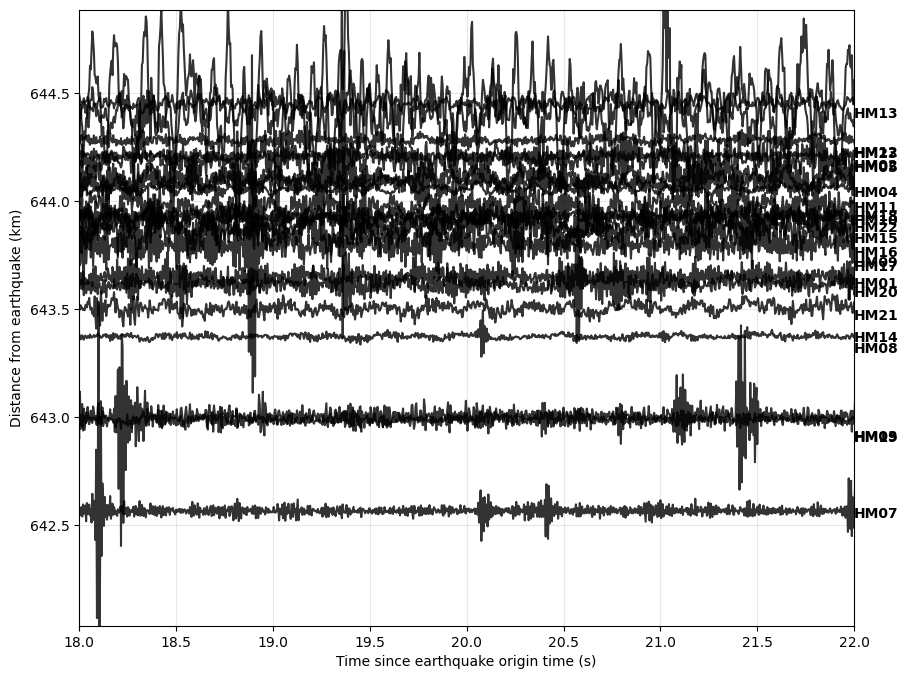

In [54]:
from obspy.geodetics import gps2dist_azimuth


names = comb['mike_name'].to_numpy()
sta_lats = temp['RU Position Latitude'].to_numpy()
sta_lons = temp['RU Position Longitude'].to_numpy()

fig, ax = plt.subplots(figsize = (10,8))
distance = []
for i in range(len(st_node)):
    tr = st_node[i]
    station = names[i]
    dist,baz,az = gps2dist_azimuth(sta_lats[i], sta_lons[i], eq_lat, eq_lon)
    ypos = (dist/1000)
    distance.append(ypos)
    ax.plot(tr.times(),ypos+((tr.data/max(tr.data))), color = 'black', alpha = 0.8)
    #ax.text(max(tr.times()),ypos, station,color = 'black', fontweight = 'bold',fontsize = 10, ha='left')
    ax.text(22,ypos, station,color = 'black', fontweight = 'bold',fontsize = 10, ha='left')
distance = np.array(distance)
ax.set_xlabel('Time since earthquake origin time (s)')
ax.set_ylabel('Distance from earthquake (km)')
ax.set_xlim(min(tr.times()), max(tr.times()))
ax.set_xlim(18,22)
ax.set_ylim(min(distance)-0.5, max(distance)+0.5)
ax.grid(alpha = 0.3)
plt.show()


In [298]:
wa = pd.read_csv('/Users/cadequigley/Downloads/homer_array_install.csv')

In [307]:
# Add lat/lon info to station dataframe
wa = pd.read_csv('/Users/cadequigley/Downloads/homer_array_install.csv')
small = wa[['mike_name',"latitude", "longitude"]].dropna()
small = small.rename(columns={"mike_name": "station_name"})
df3 = pd.merge(df3,small, on='station_name', how='outer')

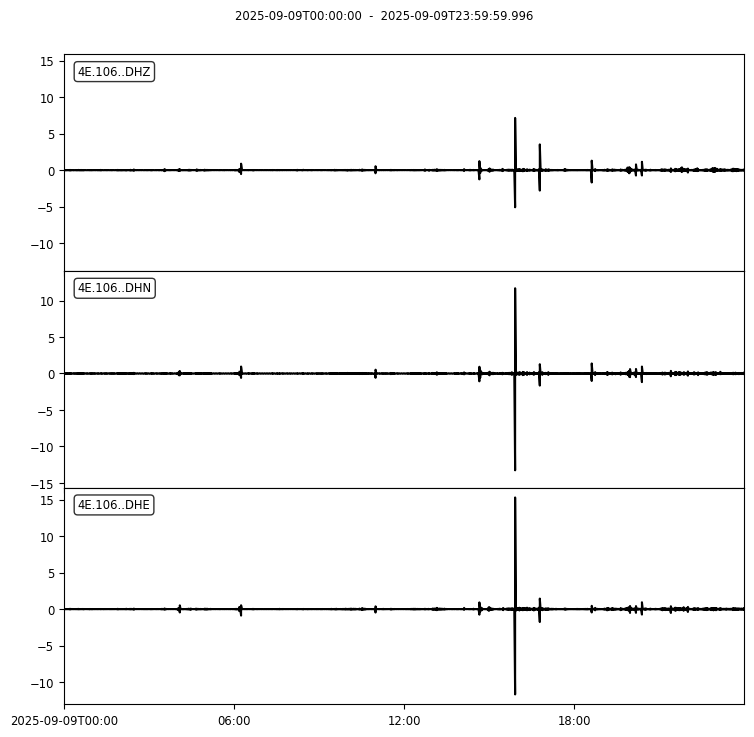

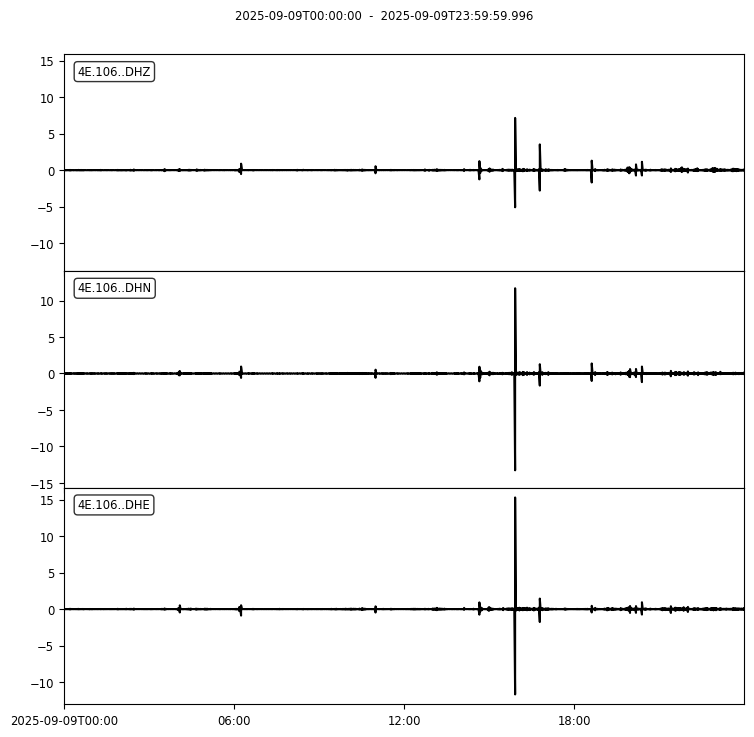

In [134]:
num = 0
times = df['Time_utc'].to_numpy()
time = UTCDateTime(times[num]) #M4.3 event
jul = time.julday
jul = 252 #276
azimuth = df['backazimuth'].to_numpy()
azimuth = azimuth[num]
stations = ['106']
#stations = ['101','103','104','105','106','107','108','109','110','111','113','114','115','116','117','118','119','120','121','124','125','112','122','123']
path = '/Volumes/BARRY_2021/102_test2/mseed/'
st_node =  read(path + '4E.'+stations[0]+'..DHZ.2025.'+str(jul))# YOUR INPUT HERE
st_node +=  read(path + '4E.'+stations[0]+'..DHN.2025.'+str(jul))# YOUR INPUT HERE
st_node +=  read(path + '4E.'+stations[0]+'..DHE.2025.'+str(jul))# YOUR INPUT HERE
for i in range(len(stations)-1):
    st_node +=  read(path + 'XX.'+stations[i+1]+'..DHZ.2025.'+str(jul))# YOUR INPUT HERE
    #st_node +=  read(path + 'XX.'+stations[i+1]+'..DHN.2025.'+str(jul))# YOUR INPUT HERE
#st_node +=  read(path + 'PF.101..DHZ.2025.226')# YOUR INPUT HERE
#st_node +=  read(path + 'PF.100..DHZ.2025.226')# YOUR INPUT HERE
#st_node +=  read(path + 'XX.Z00.HHZ.2024.093-094')# YOUR INPUT HERE
# st_node += read(...)  # <- Example code for adding two streams together

#path1 = '/Users/cadequigley/Downloads/Research/practice_deployment/fairbanks_practice_aug25_2/Other/'
#path = '/Users/cadequigley/Downloads/Research/practice_deployment/fairbanks_practice_aug25_2/Other/response_removed/'
#st_node =  read(path1 + 'PF.103..DHZ.2025.226')# YOUR INPUT HERE
#node_inv = read_inventory(path + 'PF.103..DHZ.2025.226')
#node_inv +=  read_inventory(path + 'PF.102..DHZ.2025.226')# YOUR INPUT HERE
#node_inv +=  read_inventory(path + 'PF.101..DHZ.2025.226')# YOUR INPUT HERE
#node_inv +=  read_inventory(path + 'PF.100..DHZ.2025.226')# YOUR INPUT HERE

# Task - Trim data
#starttime = UTCDateTime('2025-10-03T05:38:00')  # YOUR INPUT HERE
starttime = UTCDateTime('2025-09-09T17:36:00')  # YOUR INPUT HERE
#starttime = time 
#endtime = UTCDateTime('2024-04-02T23:58:12') + (90*60) # YOUR INPUT HERE
endtime = starttime + 1*60
#st_node.trim(starttime=starttime, endtime=endtime)

# Task - Plot waveform
#plot_waveforms(st_node)
st_node.plot()

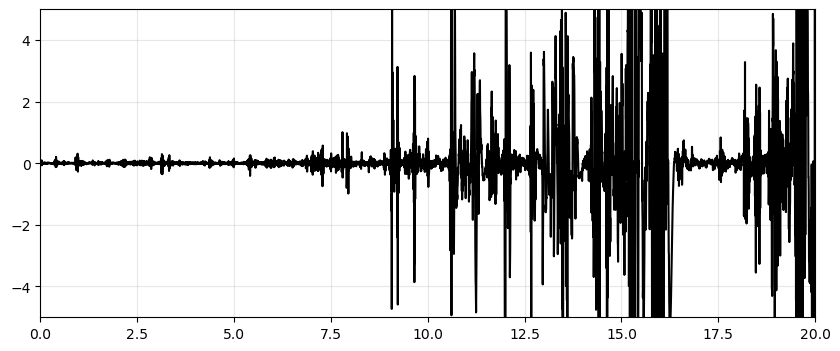

In [122]:
tr = st_node[0]
fig, ax = plt.subplots(figsize = (10,4))
ax.plot(tr.times(), tr.data, color = 'black')
ax.grid(alpha = 0.3)
ax.set_xlim(0,20)
ax.set_ylim(-5,5)
plt.show()

### Data completeness plot

In [ ]:
#### Homer D1

In [3]:
import glob

stations = ['100','101','102','103','104','105','106','107','108','109','110',
            '111','112','113','114','115','116','117','118','119','120','121','122',
           '123','124','125'] #102 has different station code
jul_start = []
jul_end = []
start_time1 = []
end_time1 = []
elapsed_time = []
for i in range(len(stations)):
    station = stations[i]
    folder = "/Volumes/ArmorATD3/ARRAYS_BACKUP/2025_09_homer_mseed_complete"
    if station == '102':
        pattern = f"{folder}/4E.{station}..DHZ.2025.*"
    else:
        pattern = f"{folder}/XX.{station}..DHZ.2025.*"
    files = glob.glob(pattern)
    julstart = files[0][-3:]
    julend = files[-1][-3:]
    jul_start.append(julstart)
    jul_end.append(julend)
    #Find UTC start and end time--------------------------
    if station == '102':
        st_start =  read(folder + '/4E.'+station+'..DHZ.2025.'+julstart)# YOUR INPUT HERE
        st_end =  read(folder + '/4E.'+station+'..DHZ.2025.'+julend)# YOUR INPUT HERE
    else:
        st_start =  read(folder + '/XX.'+station+'..DHZ.2025.'+julstart)# YOUR INPUT HERE
        st_end =  read(folder + '/XX.'+station+'..DHZ.2025.'+julend)# YOUR INPUT HERE
    tmin = min([tr.stats.starttime for tr in st_start])
    tmax = max([tr.stats.endtime for tr in st_end])
    elapsed = (tmax - tmin)/(60*60*24)
    print(elapsed)
    elapsed_time.append(elapsed)
    start_time1.append(tmin)
    end_time1.append(tmax)
    print(station+' finished')
#print(jul_start)
#print(jul_end)
df = pd.DataFrame({
        'station': stations,
        'julday_start_d1': jul_start,
        'jul_day_end_d1': jul_end,
        'start_mseed_d1': start_time1,
        'end_mseed_d1': end_time1,
        'elapsed_time_d1': elapsed_time
                  
                  })

33.30173606481481
100 finished
33.84652773148148
101 finished
33.78194439814815
102 finished
33.07743050925926
103 finished
33.08020828703703
104 finished
33.04166662037037
105 finished
33.19305550925926
106 finished
31.29513884259259
107 finished
33.04652773148148
108 finished
31.573611064814813
109 finished
33.064930509259256
110 finished
33.0718749537037
111 finished
34.03055550925926
112 finished
33.07777773148148
113 finished
33.066319398148146
114 finished
31.908680509259256
115 finished
31.710069398148146
116 finished
31.84652773148148
117 finished
31.888194398148148
118 finished
27.620138842592592
119 finished
33.81215273148148
120 finished
34.3437499537037
121 finished
33.72986106481481
122 finished
33.75277773148148
123 finished
33.2593749537037
124 finished
33.04826384259259
125 finished


In [ ]:
#### Homer D2

In [4]:
import glob

stations = ['100','101','102','103','104','105','106','107','108','109','110',
            '111','112','113','114','115','116','117','118','119','120','121',
           '123','124','125'] #122 does not have data
jul_start = []
jul_end = []
start_time = []
end_time = []
elapsed_time = []
for i in range(len(stations)):
    station = stations[i]
    folder = "/Volumes/BARRY_2021/HOMER_DATA/2025_10_homer_d2_mseed"
    #if station == '102':
    pattern = f"{folder}/4E.{station}..DHZ.2025.*"
    #else:
    
    files = glob.glob(pattern)
    julstart = files[0][-3:]
    julend = files[-1][-3:]
    jul_start.append(julstart)
    jul_end.append(julend)
    #Find UTC start and end time--------------------------
    
    st_start =  read(folder + '/4E.'+station+'..DHZ.2025.'+julstart)# YOUR INPUT HERE
    st_end =  read(folder + '/4E.'+station+'..DHZ.2025.'+julend)# YOUR INPUT HERE
    
    tmin = min([tr.stats.starttime for tr in st_start])
    tmax = max([tr.stats.endtime for tr in st_end])
    elapsed = (tmax - tmin)/(60*60*24)
    print(elapsed)
    elapsed_time.append(elapsed)
    start_time.append(tmin)
    end_time.append(tmax)
    print(station+' finished')
#print(jul_start)
#print(jul_end)
df2 = pd.DataFrame({
        'station': stations,
        'julday_start_d2': jul_start,
        'jul_day_end_d2': jul_end,
        'start_mseed_d2': start_time,
        'end_mseed_d2': end_time,
        'elapsed_time_d2': elapsed_time
                  
                  })

30.12465273148148
100 finished
31.072569398148147
101 finished
30.09965273148148
102 finished
31.052430509259256
103 finished
30.981944398148148
104 finished
30.939236064814814
105 finished
30.89166662037037
106 finished
31.0968749537037
107 finished
31.00763884259259
108 finished
31.010069398148147
109 finished
29.90555550925926
110 finished
30.982986064814813
111 finished
28.54791662037037
112 finished
31.048611064814814
113 finished
30.934722175925923
114 finished
31.005208287037036
115 finished
31.013194398148148
116 finished
31.072569398148147
117 finished
31.00451384259259
118 finished
31.148611064814812
119 finished
31.11423606481481
120 finished
31.22465273148148
121 finished
31.1781249537037
123 finished
30.089583287037033
124 finished
30.88263884259259
125 finished


In [9]:
time1

2025-09-09T01:26:39.672000Z

In [11]:
df3

,station,julday_start_d1,jul_day_end_d1,start_mseed_d1,end_mseed_d1,elapsed_time_d1,julday_start_d2,jul_day_end_d2,start_mseed_d2,end_mseed_d2,elapsed_time_d2,total_time_data
0,100,251,285,2025-09-08T23:05:41.984000Z,2025-10-12T06:20:11.980000Z,33.301736,285,315,2025-10-12T20:53:03.956000Z,2025-11-11T23:52:33.952000Z,30.124653,63.426389
1,101,252,285,2025-09-09T00:08:21.244000Z,2025-10-12T20:27:21.240000Z,33.846528,285,316,2025-10-12T20:35:50.708000Z,2025-11-12T22:20:20.704000Z,31.072569,64.919097
2,102,251,285,2025-09-08T23:39:48.964000Z,2025-10-12T18:25:48.960000Z,33.781944,285,315,2025-10-12T21:18:19.028000Z,2025-11-11T23:41:49.024000Z,30.099653,63.881597
3,103,251,284,2025-09-08T20:17:42.232000Z,2025-10-11T22:09:12.228000Z,33.077431,284,315,2025-10-11T22:17:36.140000Z,2025-11-11T23:33:06.136000Z,31.052431,64.129861
4,104,251,284,2025-09-08T19:54:53.192000Z,2025-10-11T21:50:23.188000Z,33.080208,284,315,2025-10-11T21:59:11.048000Z,2025-11-11T21:33:11.044000Z,30.981944,64.062153
5,105,251,284,2025-09-08T21:25:14.036000Z,2025-10-11T22:25:14.032000Z,33.041667,284,315,2025-10-11T22:36:30.512000Z,2025-11-11T21:09:00.508000Z,30.939236,63.980903
6,106,251,284,2025-09-08T18:40:43.236000Z,2025-10-11T23:18:43.232000Z,33.193056,284,315,2025-10-11T23:26:33.112000Z,2025-11-11T20:50:33.108000Z,30.891667,64.084722
7,107,251,283,2025-09-08T19:05:22.500000Z,2025-10-10T02:10:22.496000Z,31.295139,284,315,2025-10-11T20:50:39.112000Z,2025-11-11T23:10:09.108000Z,31.096875,62.392014
8,108,251,284,2025-09-08T18:16:56.724000Z,2025-10-11T19:23:56.720000Z,33.046528,284,315,2025-10-11T19:33:20.996000Z,2025-11-11T19:44:20.992000Z,31.007639,64.054167
9,109,251,283,2025-09-08T17:55:33.640000Z,2025-10-10T07:41:33.636000Z,31.573611,284,315,2025-10-11T19:12:55.620000Z,2025-11-11T19:27:25.616000Z,31.010069,62.583680


In [27]:
start = UTCDateTime(start_dep)
end = UTCDateTime(end_dep)

df3 = pd.merge(df,df2, on='station', how='outer')
df3['total_time_data'] = df3['elapsed_time_d1']+df3['elapsed_time_d2']
time_del_start = []
time_del_end = []
for i in range(len(df3)):
    time1 = df3['start_mseed_d1'].to_numpy()[i]
    #time2 = df4['end_mseed_d2'].to_numpy()[i]
    time_del_start.append(abs(start - UTCDateTime(time1))/(60*60))
    #time_del_end.append(abs(end - UTCDateTime(time2))/(60*60))
df3['missing_time_start'] = time_del_start
df4 = df3.dropna()
#time_del_start = []
time_del_end = []
for i in range(len(df4)):
    #time1 = df4['start_mseed_d1'].to_numpy()[i]
    time2 = df4['end_mseed_d2'].to_numpy()[i]
    #time_del_start.append(abs(start - UTCDateTime(time1))/(60*60))
    time_del_end.append(abs(end - UTCDateTime(time2))/(60*60))
#df4['missing_time_start'] = time_del_start
df4['missing_time_end'] = time_del_end
#temp0 = df4['missing_time_start']
temp01 = df4['missing_time_end']
temp = pd.DataFrame((df4['start_mseed_d2'] - df4['end_mseed_d1'])/(60*60), columns = ['missing_time_hours'])
temp2 = df4['station']
df5 = pd.concat([temp,temp2,temp01], axis = 1)
df3 = pd.merge(df3,df5, on='station', how='outer')
df3['bear_removal_time_d1'] = np.array([0,0,0,0,0,0,0,0,0,0,0,0,'2025-10-03T05:56:00',0,0,0,0,0,0,0,0,0,'2025-10-03T05:38:00','2025-09-09T17:36:00',0,0])
df3['bear_removal_time_d2'] = np.array([0,0,0,0,0,0,0,0,"2025-10-17T11:08:00",0,0,0,'2025-10-20T17:41:00',0,0,0,0,0,0,0,0,'2025-10-21T03:38:00',0,0,0,0])
df3['station_name'] = np.array(['HM11','HM12','HM17','HM13','HM14','HM19','HM24','HM25','HM22','HM21','HM16','HM10','HM05','HM26','HM20',
                                'HM15','HM09','HM08','HM04','HM03','HM07','HM01','HM06','HM02','HM18','HM23'])
df3 = df3.sort_values(by = 'station_name')
df3.to_csv('/Users/cadequigley/Downloads/Research/deployment_array_design/homer_mseed_completeness.csv')

/var/folders/rg/vbnq7_qj6ks5m0l7cnnw46y00000gn/T/ipykernel_94099/1879931369.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['missing_time_end'] = time_del_end


In [6]:
df3 = pd.read_csv('/Users/cadequigley/Downloads/Research/deployment_array_design/homer_mseed_completeness.csv')
df3['start_datetime'] = pd.to_datetime(df3['start_mseed_d1'], utc=True)
df3['end_datetime'] = pd.to_datetime(df3['end_mseed_d2'], utc=True)


start_dep = df3['start_datetime'].min()
end_dep = df3['end_datetime'].max()
print(start_dep)
print(end_dep)
start_dep = UTCDateTime(start_dep)
end_dep = UTCDateTime(end_dep)

2025-09-07 23:32:56.428000+00:00
2025-11-13 00:09:49.076000+00:00


In [13]:
df3

,station,julday_start_d1,jul_day_end_d1,start_mseed_d1,end_mseed_d1,elapsed_time_d1,julday_start_d2,jul_day_end_d2,start_mseed_d2,end_mseed_d2,elapsed_time_d2,total_time_data,missing_time_hours,missing_time_start,missing_time_end,bear_removal_time_d1,bear_removal_time_d2,station_name
21,121,250,285,2025-09-07T23:32:56.428000Z,2025-10-12T07:47:56.424000Z,34.343750,285,317,2025-10-12T18:46:19.080000Z,2025-11-13T00:09:49.076000Z,31.224653,65.568403,10.97296,0.000000,0.000000,0,2025-10-21T03:38:00,HM01
23,123,252,285,2025-09-09T01:11:25.516000Z,2025-10-12T19:15:25.512000Z,33.752778,285,316,2025-10-12T19:24:45.560000Z,2025-11-12T23:41:15.556000Z,31.178125,64.930903,0.155569,25.641413,0.475978,2025-09-09T17:36:00,0,HM02
19,119,252,279,2025-09-09T00:47:25.872000Z,2025-10-06T15:40:25.868000Z,27.620139,285,316,2025-10-12T19:48:17.824000Z,2025-11-12T23:22:17.820000Z,31.148611,58.768750,148.131099,25.241512,0.792016,0,0,HM03
18,118,252,284,2025-09-09T22:23:46.604000Z,2025-10-11T19:42:46.600000Z,31.888194,284,315,2025-10-11T19:53:34.212000Z,2025-11-11T20:00:04.208000Z,31.004514,62.892708,0.179892,46.847271,28.162463,0,0,HM04
12,112,251,285,2025-09-08T00:04:41.636000Z,2025-10-12T00:48:41.632000Z,34.030556,285,313,2025-10-12T00:55:38.120000Z,2025-11-09T14:04:38.116000Z,28.547917,62.578472,0.115691,0.529224,82.086378,2025-10-03T05:56:00,2025-10-20T17:41:00,HM05
22,122,252,285,2025-09-09T01:26:39.672000Z,2025-10-12T18:57:39.668000Z,33.729861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-03T05:38:00,0,HM06
20,120,252,285,2025-09-09T00:28:44.052000Z,2025-10-12T19:58:14.048000Z,33.812153,285,316,2025-10-12T20:18:23.988000Z,2025-11-12T23:02:53.984000Z,31.114236,64.926389,0.336094,24.929896,1.115303,0,0,HM07
17,117,253,284,2025-09-10T00:40:42.244000Z,2025-10-11T20:59:42.240000Z,31.846528,284,315,2025-10-11T21:10:36.456000Z,2025-11-11T22:55:06.452000Z,31.072569,62.919097,0.181727,49.129393,25.245173,0,0,HM08
16,116,253,284,2025-09-10T01:35:19.880000Z,2025-10-11T18:37:49.876000Z,31.710069,284,315,2025-10-11T18:51:36.164000Z,2025-11-11T19:10:36.160000Z,31.013194,62.723264,0.229524,50.039848,28.986921,0,0,HM09
11,111,251,285,2025-09-08T22:44:44.452000Z,2025-10-12T00:28:14.448000Z,33.071875,285,316,2025-10-12T00:36:28.036000Z,2025-11-12T00:11:58.032000Z,30.982986,64.054861,0.137108,23.196673,23.964179,0,0,HM10


In [25]:
elapsed_start

array([ 0.        , 25.64141333, 25.24151222, 46.84727111,  0.52922444,
        0.        , 24.92989556, 49.12939333, 50.03984778, 23.19667333,
       23.54598778, 24.59022667, 20.74605667, 20.36576778, 48.22597111,
       22.91343889, 24.11459333, 23.85939   , 21.87155778, 21.52361667,
       18.37700333, 18.73341556, 22.33873111, 19.12966889, 19.54057556,
       19.92382111])

In [28]:

import datetime as dt

df3 = pd.read_csv('/Users/cadequigley/Downloads/Research/deployment_array_design/homer_mseed_completeness.csv')

df5 = df3.copy()
df5 = df5.fillna(0)
df5 = df5.sort_values(by = 'station_name')
#df5 = df5.dropna()
times_start = df5['start_mseed_d1'].to_numpy()
times_end = df5['end_mseed_d1'].to_numpy()
times_start2 = df5['start_mseed_d2'].to_numpy()
times_end2 = df5['end_mseed_d2'].to_numpy()
elapsed_d1 = df5['elapsed_time_d1'].to_numpy()
elapsed_d2 = df5['elapsed_time_d2'].to_numpy()
elapsed_inter = df5['missing_time_hours'].to_numpy()
stations = df5['station_name'].to_numpy()
bear_time_d1 = df5['bear_removal_time_d1'].to_numpy()
bear_time_d2 = df5['bear_removal_time_d2'].to_numpy()

elapsed_start = df5['missing_time_start'].to_numpy()
elapsed_end = df5['missing_time_end'].to_numpy()

matplot_begin = []
matplot_end = []
missing_start = []
missing_end = []

matplot_start1 = []
matplot_start2 = []
matplot_start3 = []
duration1 = []
duration2 = []
inter = []
bear_start = []
bear_duration = []
bear_elapsed1 = []
bear_start2 = []
bear_duration2 = []
bear_elapsed2 = []
no_data = []
for i in range(len(times_start)):
    ##Missing time start-------------
    
    wa = str(start_dep)
    matplot_begin.append(dt.datetime(int(wa[0:4]),int(wa[5:7]), int(wa[8:10]), int(wa[11:13]),int(wa[14:16]),int(wa[17:19])))
    missing_start.append(dt.timedelta(hours = elapsed_start[i]))
    ##Missing time end-------------
    if str(times_end2[i]) == '0':
        matplot_end.append(0)
        missing_end.append(0)

    else:
        wa = str(times_end2[i])
        matplot_end.append(dt.datetime(int(wa[0:4]),int(wa[5:7]), int(wa[8:10]), int(wa[11:13]),int(wa[14:16]),int(wa[17:19])))
        missing_end.append(dt.timedelta(hours = elapsed_end[i]))
    
    ##First segment-----------------
    wa = str(times_start[i])
    matplot_start1.append(dt.datetime(int(wa[0:4]),int(wa[5:7]), int(wa[8:10]), int(wa[11:13]),int(wa[14:16]),int(wa[17:19])))
    duration1.append(dt.timedelta(hours = elapsed_d1[i]*24))
    ##Between deployments-----------------
    wa = str(times_end[i])
    matplot_start2.append(dt.datetime(int(wa[0:4]),int(wa[5:7]), int(wa[8:10]), int(wa[11:13]),int(wa[14:16]),int(wa[17:19])))
    inter.append(dt.timedelta(hours = elapsed_inter[i]))
    ##Second segment-----------------
    if str(times_start2[i]) == '0': #stations that don't have any data-----------------
        wa = str(times_end[i])
        matplot_start3.append(dt.datetime(int(wa[0:4]),int(wa[5:7]), int(wa[8:10]), int(wa[11:13]),int(wa[14:16]),int(wa[17:19])))
        duration2.append(dt.timedelta(hours = 31*24))
        no_data.append(1)
    else:
        wa = str(times_start2[i])
        matplot_start3.append(dt.datetime(int(wa[0:4]),int(wa[5:7]), int(wa[8:10]), int(wa[11:13]),int(wa[14:16]),int(wa[17:19])))
        duration2.append(dt.timedelta(hours = elapsed_d2[i]*24))
        no_data.append(0)
    ##Bear times D1------------
    if bear_time_d1[i] == '0':
        bear_start.append(0)
        bear_duration.append(0)
        bear_elapsed1.append(0)
    else:
        wa = bear_time_d1[i]
        bear_start.append(dt.datetime(int(wa[0:4]),int(wa[5:7]), int(wa[8:10]), int(wa[11:13]),int(wa[14:16])))
        bear_elapsed = abs(UTCDateTime(wa) - UTCDateTime(times_end[i]))/(60*60*24)
        bear_duration.append(dt.timedelta(hours = bear_elapsed*24))
        bear_elapsed1.append(bear_elapsed)
    ##Bear times D2------------
    if bear_time_d2[i] == '0':
        bear_start2.append(0)
        bear_duration2.append(0)
        bear_elapsed2.append(0)
    else:
        wa = bear_time_d2[i]
        bear_start2.append(dt.datetime(int(wa[0:4]),int(wa[5:7]), int(wa[8:10]), int(wa[11:13]),int(wa[14:16])))
        bear_elapsed = abs(UTCDateTime(wa) - UTCDateTime(times_end2[i]))/(60*60*24)
        bear_duration2.append(dt.timedelta(hours = bear_elapsed*24))
        bear_elapsed2.append(bear_elapsed)
        
    

In [17]:
wa

'0'

In [29]:
df3 = df3.fillna(0)
df3['missing_time_bears_d1'] = bear_elapsed1
df3['missing_time_bears_d2'] = bear_elapsed2
denominator = df3['elapsed_time_d1'].to_numpy()+df3['elapsed_time_d2'].to_numpy()+(df3['missing_time_hours'].to_numpy()/24) #HM06 wrong doing this, fixing it manually
numerator = df3['elapsed_time_d1'].to_numpy()+df3['elapsed_time_d2'].to_numpy()-(df3['missing_time_hours'].to_numpy()/24)-df3['missing_time_bears_d1']-df3['missing_time_bears_d2']
df3['data_completeness'] = numerator/denominator

###Completeness in relation to whole array----------------------
denominator = df3['elapsed_time_d1'].to_numpy()+df3['elapsed_time_d2'].to_numpy()+(df3['missing_time_hours'].to_numpy()/24)+(df3['missing_time_start'].to_numpy()/24)+(df3['missing_time_end'].to_numpy()/24) #HM06 wrong doing this, fixing it manually
numerator = df3['elapsed_time_d1'].to_numpy()+df3['elapsed_time_d2'].to_numpy()-(df3['missing_time_hours'].to_numpy()/24)-(df3['missing_time_start'].to_numpy()/24)-(df3['missing_time_end'].to_numpy()/24)-df3['missing_time_bears_d1']-df3['missing_time_bears_d2']
df3['data_completeness_all'] = numerator/denominator

df3
df3.to_csv('/Users/cadequigley/Downloads/Research/deployment_array_design/homer_mseed_completeness.csv')

In [22]:
missing_start

[datetime.timedelta(0),
 datetime.timedelta(days=1, seconds=5909, microseconds=88000),
 datetime.timedelta(days=1, seconds=4469, microseconds=444000),
 datetime.timedelta(days=1, seconds=82250, microseconds=176000),
 datetime.timedelta(seconds=1905, microseconds=208000),
 datetime.timedelta(0),
 datetime.timedelta(days=1, seconds=3347, microseconds=624000),
 datetime.timedelta(days=2, seconds=4065, microseconds=816000),
 datetime.timedelta(days=2, seconds=7343, microseconds=452000),
 datetime.timedelta(seconds=83508, microseconds=24000),
 datetime.timedelta(seconds=84765, microseconds=556000),
 datetime.timedelta(days=1, seconds=2124, microseconds=816000),
 datetime.timedelta(seconds=74685, microseconds=804000),
 datetime.timedelta(seconds=73316, microseconds=764000),
 datetime.timedelta(days=2, seconds=813, microseconds=496000),
 datetime.timedelta(seconds=82488, microseconds=380000),
 datetime.timedelta(days=1, seconds=412, microseconds=536000),
 datetime.timedelta(seconds=85893, mic

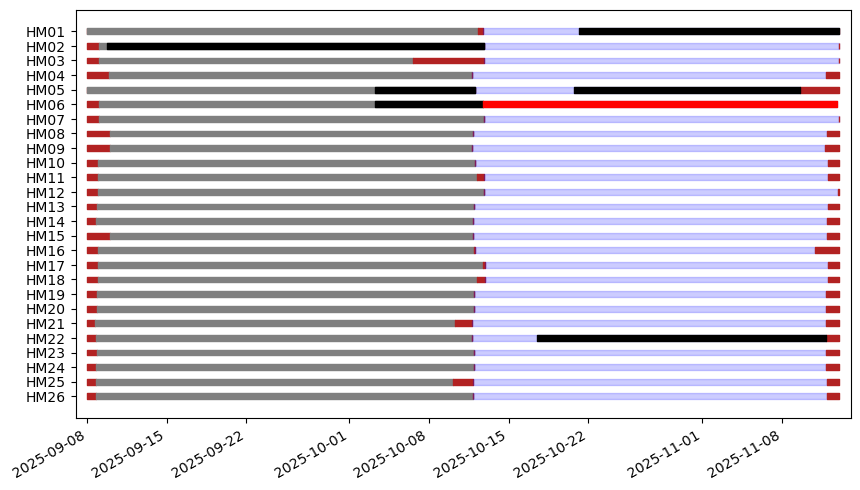

In [31]:
import datetime as dt
#cpu_1 = [(0, 3), (3.5, 1), (5, 5)]

fig, ax = plt.subplots(figsize = (10,6))
# broken_barh(xranges, (ymin, height))
for i in range(len(stations)):
    work0 = [(matplot_begin[i],missing_start[i])]
    work1 = [(matplot_start1[i],duration1[i])]
    work2 = [(matplot_start2[i],inter[i])]
    work3 = [(matplot_start3[i], duration2[i])]
    work4 = [(matplot_end[i],missing_end[i])]
    #nonwork = 
    ax.broken_barh(work0, (-0.2+i, 0.4), color = 'firebrick') #time between d1 and d2
    ax.broken_barh(work1, (-0.2+i, 0.4), color = 'gray' ) #working time d1
    ax.broken_barh(work2, (-0.2+i, 0.4), color = 'firebrick') #time between d1 and d2
    ax.broken_barh(work3, (-0.2+i, 0.4), color = 'blue', alpha = 0.2) #working time d2
    ax.broken_barh(work4, (-0.2+i, 0.4), color = 'firebrick') #time between d1 and d2
    #Add bear removal coloring----------------------
    if bear_duration[i] == 0:
        wawa = 0
    else:
        work4 = [(bear_start[i], bear_duration[i])]
        ax.broken_barh(work4, (-0.2+i, 0.4), color = 'black') #working time d2
        
    if bear_duration2[i] == 0:
        wawa =0
    else:
        work6 = [(bear_start2[i], bear_duration2[i])]
        ax.broken_barh(work6, (-0.2+i, 0.4), color = 'black') #working time d2
    #Add no data coloring--------------------------
    if no_data[i] == 0:
        wawa = 0
    else:
        work5 = work3
        ax.broken_barh(work5, (-0.2+i, 0.4), color = 'red') #working time d2

fig.autofmt_xdate()
#ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
#ax.set_xlim(0, 10)
ax.set_xlim(pd.to_datetime("2025-09-07"),
            pd.to_datetime("2025-11-14"))

ax.set_yticks(range(len(stations)),labels=list(stations))
ax.invert_yaxis()
plt.savefig('data_availability_homer_array.png', transparent=True, dpi = 720)
plt.show()


### Finding bears D2

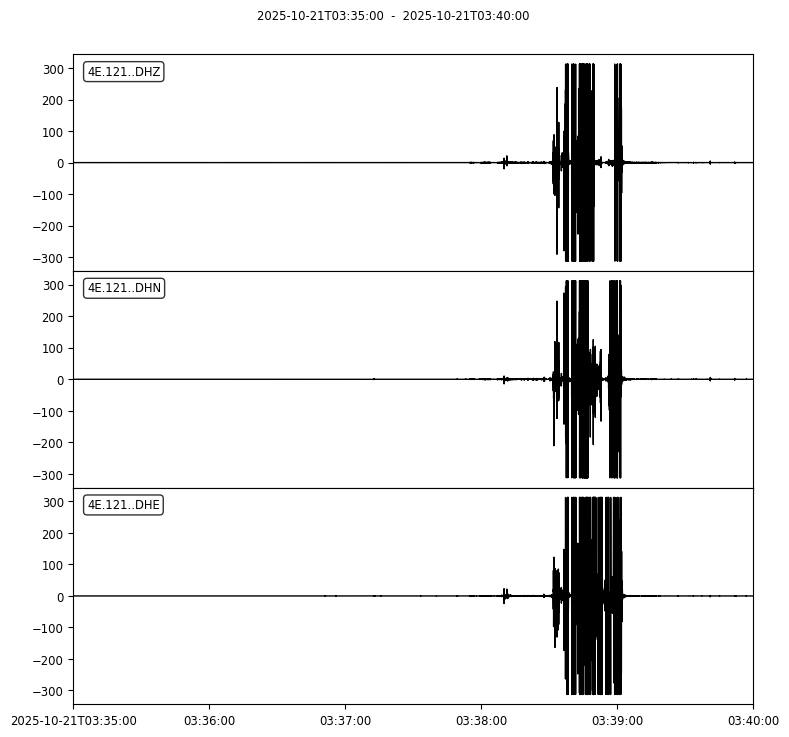

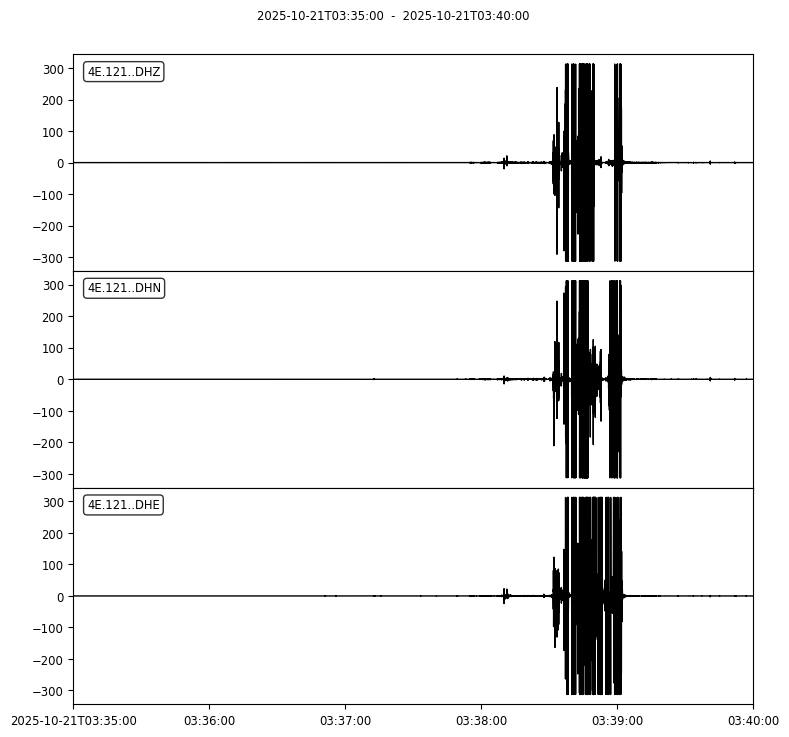

In [411]:
num = 0
#times = df['Time_utc'].to_numpy()
#time = UTCDateTime(times[num]) #M4.3 event
#jul = time.julday
jul = 294 #276
#azimuth = df['backazimuth'].to_numpy()
#azimuth = azimuth[num]
stations = ['121'] #108
#stations = ['101','103','104','105','106','107','108','109','110','111','113','114','115','116','117','118','119','120','121','124','125','112','122','123']
path = "/Volumes/ArmorATD3/ARRAYS_BACKUP/2025_10_homer_d2_mseed/"
#path = "/Volumes/ArmorATD3/ARRAYS_BACKUP/2025_10_homer_d2_mseed/"
st_node =  read(path + '4E.'+stations[0]+'..DHZ.2025.'+str(jul))# YOUR INPUT HERE
st_node +=  read(path + '4E.'+stations[0]+'..DHN.2025.'+str(jul))# YOUR INPUT HERE
st_node +=  read(path + '4E.'+stations[0]+'..DHE.2025.'+str(jul))# YOUR INPUT HERE
for i in range(len(stations)-1):
    st_node +=  read(path + '4E.'+stations[i+1]+'..DHZ.2025.'+str(jul))# YOUR INPUT HERE
    st_node +=  read(path + '4E.'+stations[i+1]+'..DHN.2025.'+str(jul))# YOUR INPUT HERE
    st_node +=  read(path + '4E.'+stations[i+1]+'..DHE.2025.'+str(jul))# YOUR INPUT HERE
    #st_node +=  read(path + 'XX.'+stations[i+1]+'..DHN.2025.'+str(jul))# YOUR INPUT HERE
#st_node +=  read(path + 'PF.101..DHZ.2025.226')# YOUR INPUT HERE
#st_node +=  read(path + 'PF.100..DHZ.2025.226')# YOUR INPUT HERE
#st_node +=  read(path + 'XX.Z00.HHZ.2024.093-094')# YOUR INPUT HERE
# st_node += read(...)  # <- Example code for adding two streams together

#path1 = '/Users/cadequigley/Downloads/Research/practice_deployment/fairbanks_practice_aug25_2/Other/'
#path = '/Users/cadequigley/Downloads/Research/practice_deployment/fairbanks_practice_aug25_2/Other/response_removed/'
#st_node =  read(path1 + 'PF.103..DHZ.2025.226')# YOUR INPUT HERE
#node_inv = read_inventory(path + 'PF.103..DHZ.2025.226')
#node_inv +=  read_inventory(path + 'PF.102..DHZ.2025.226')# YOUR INPUT HERE
#node_inv +=  read_inventory(path + 'PF.101..DHZ.2025.226')# YOUR INPUT HERE
#node_inv +=  read_inventory(path + 'PF.100..DHZ.2025.226')# YOUR INPUT HERE

# Task - Trim data
#starttime = UTCDateTime('2025-10-03T05:38:00')  # YOUR INPUT HERE
#starttime = UTCDateTime('2025-09-09T17:36:00')  # YOUR INPUT HERE
starttime = UTCDateTime('2025-10-21T03:35:00')  # YOUR INPUT HERE
#starttime = time 
#endtime = UTCDateTime('2024-04-02T23:58:12') + (90*60) # YOUR INPUT HERE
endtime = starttime + 5*60
st_node.trim(starttime=starttime, endtime=endtime)

# Task - Plot waveform
#plot_waveforms(st_node)
st_node.plot()

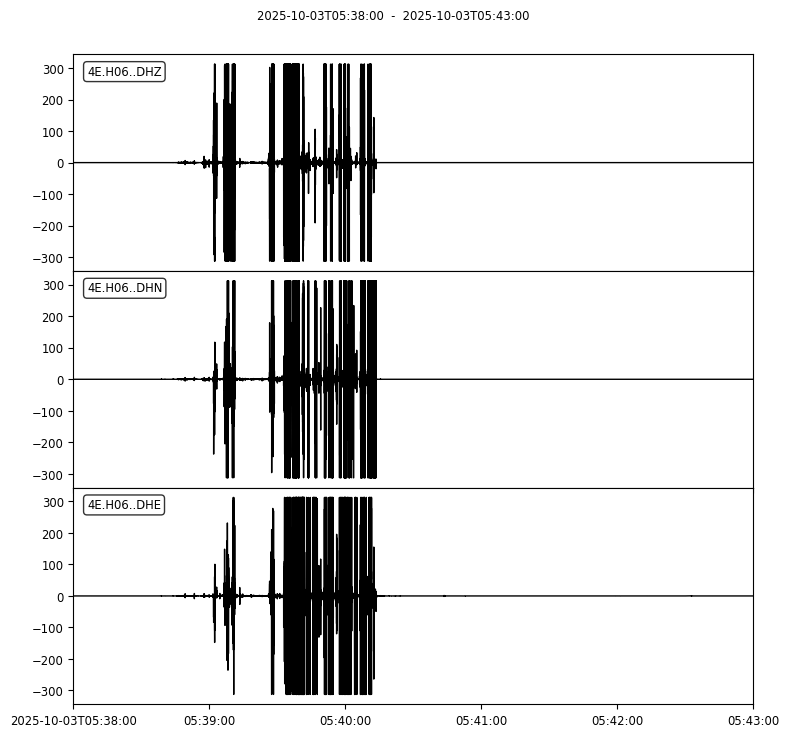

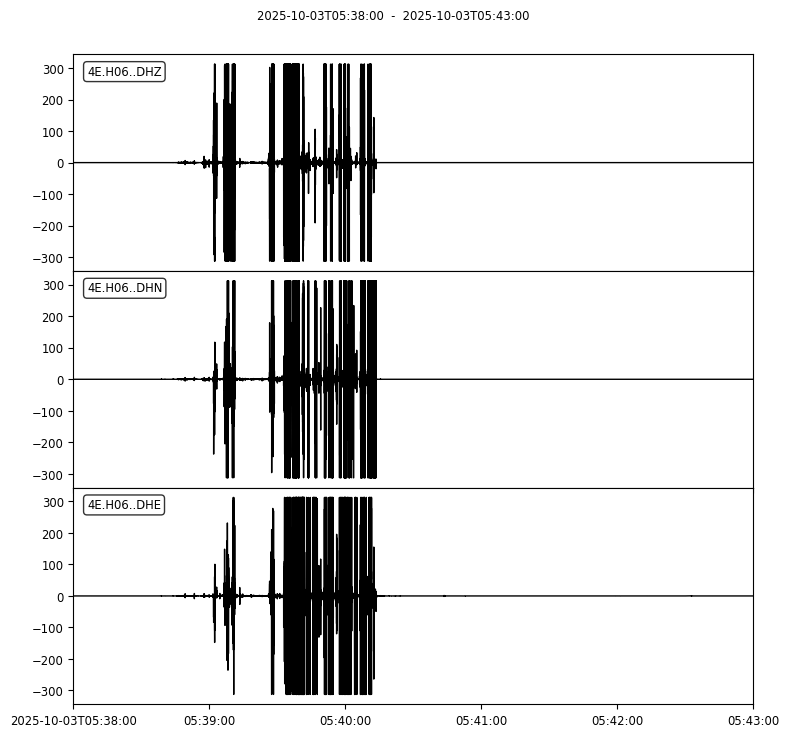

In [493]:

time = UTCDateTime('2025-10-03T05:38:00') #M4.3 event
jul = time.julday
#jul = 294 #276
#azimuth = df['backazimuth'].to_numpy()
#azimuth = azimuth[num]
stations = ['122'] #108,112
#stations = ['101','103','104','105','106','107','108','109','110','111','113','114','115','116','117','118','119','120','121','124','125','112','122','123']
path = "/Volumes/ArmorATD3/ARRAYS_BACKUP/2025_09_homer_mseed_complete/"
#path = "/Volumes/ArmorATD3/ARRAYS_BACKUP/2025_10_homer_d2_mseed/"
st_node =  read(path + 'XX.'+stations[0]+'..DHZ.2025.'+str(jul))# YOUR INPUT HERE
st_node +=  read(path + 'XX.'+stations[0]+'..DHN.2025.'+str(jul))# YOUR INPUT HERE
st_node +=  read(path + 'XX.'+stations[0]+'..DHE.2025.'+str(jul))# YOUR INPUT HERE
for i in range(len(stations)-1):
    st_node +=  read(path + 'XX.'+stations[i+1]+'..DHZ.2025.'+str(jul))# YOUR INPUT HERE
    st_node +=  read(path + 'XX.'+stations[i+1]+'..DHN.2025.'+str(jul))# YOUR INPUT HERE
    st_node +=  read(path + 'XX.'+stations[i+1]+'..DHE.2025.'+str(jul))# YOUR INPUT HERE
    #st_node +=  read(path + 'XX.'+stations[i+1]+'..DHN.2025.'+str(jul))# YOUR INPUT HERE
#st_node +=  read(path + 'PF.101..DHZ.2025.226')# YOUR INPUT HERE
#st_node +=  read(path + 'PF.100..DHZ.2025.226')# YOUR INPUT HERE
#st_node +=  read(path + 'XX.Z00.HHZ.2024.093-094')# YOUR INPUT HERE
# st_node += read(...)  # <- Example code for adding two streams together

#path1 = '/Users/cadequigley/Downloads/Research/practice_deployment/fairbanks_practice_aug25_2/Other/'
#path = '/Users/cadequigley/Downloads/Research/practice_deployment/fairbanks_practice_aug25_2/Other/response_removed/'
#st_node =  read(path1 + 'PF.103..DHZ.2025.226')# YOUR INPUT HERE
#node_inv = read_inventory(path + 'PF.103..DHZ.2025.226')
#node_inv +=  read_inventory(path + 'PF.102..DHZ.2025.226')# YOUR INPUT HERE
#node_inv +=  read_inventory(path + 'PF.101..DHZ.2025.226')# YOUR INPUT HERE
#node_inv +=  read_inventory(path + 'PF.100..DHZ.2025.226')# YOUR INPUT HERE

# Task - Trim data
#starttime = UTCDateTime('2025-10-03T05:38:00')  # YOUR INPUT HERE
starttime = UTCDateTime('2025-09-09T17:35:00')  # YOUR INPUT HERE
starttime = UTCDateTime('2025-10-03T05:38:00')  # YOUR INPUT HERE
#starttime = UTCDateTime('2025-10-21T03:35:00')  # YOUR INPUT HERE
#starttime = time 
#endtime = UTCDateTime('2024-04-02T23:58:12') + (90*60) # YOUR INPUT HERE
endtime = starttime + 5*60
st_node.trim(starttime=starttime, endtime=endtime)

# Task - Plot waveform
#plot_waveforms(st_node)
st_node.plot()

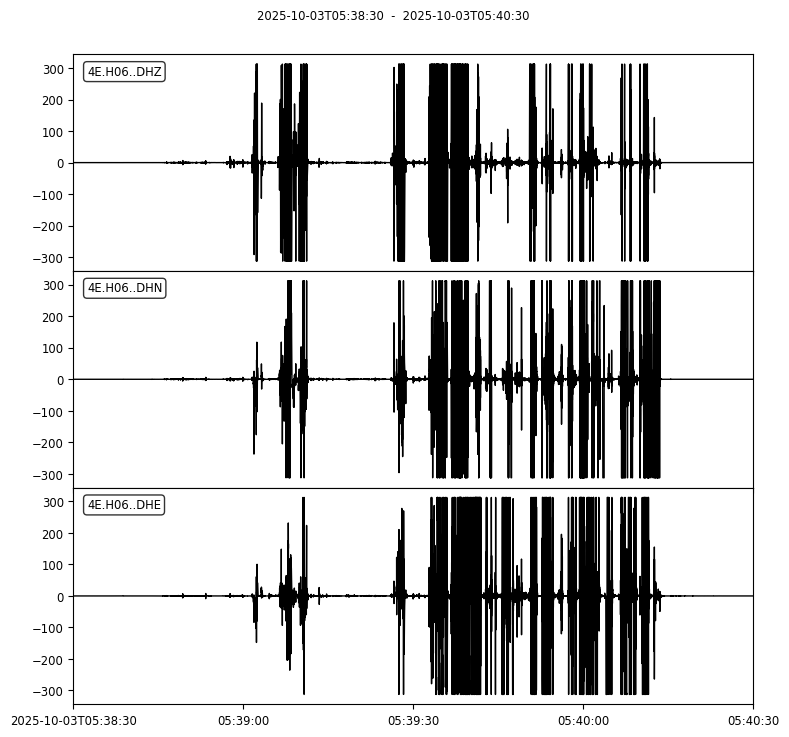

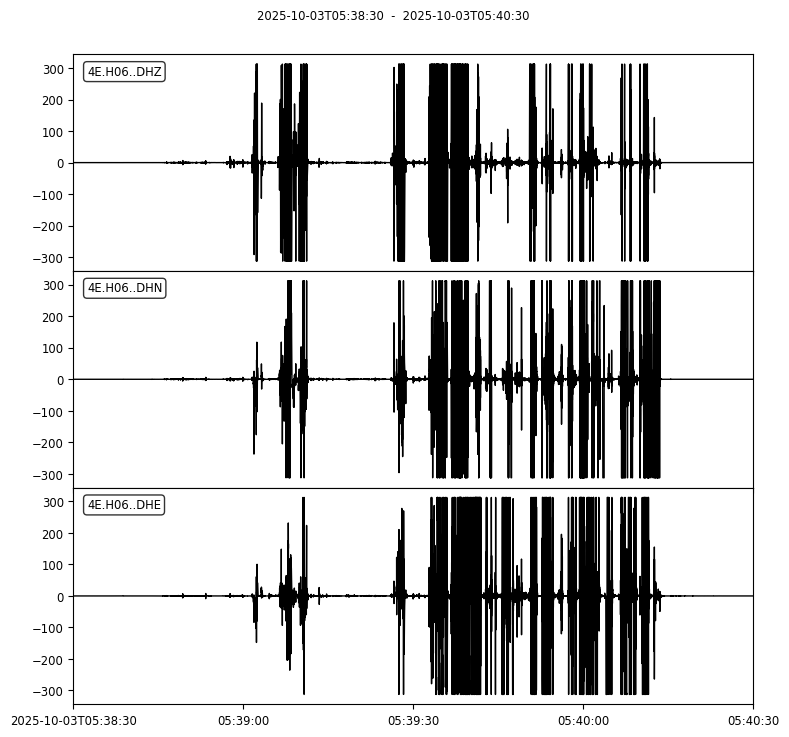

In [494]:
st = st_node.copy()
#starttime = UTCDateTime('2025-09-09T17:36:09')  # YOUR INPUT HERE
#starttime = UTCDateTime('2025-09-09T17:36:20')  # YOUR INPUT HE
starttime = UTCDateTime('2025-10-03T05:56:20')  # YOUR INPUT HERE
starttime = UTCDateTime('2025-10-03T05:38:30')
#starttime = time 
#endtime = UTCDateTime('2024-04-02T23:58:12') + (90*60) # YOUR INPUT HERE
endtime = starttime + 120
st.trim(starttime=starttime, endtime=endtime)
st.plot()

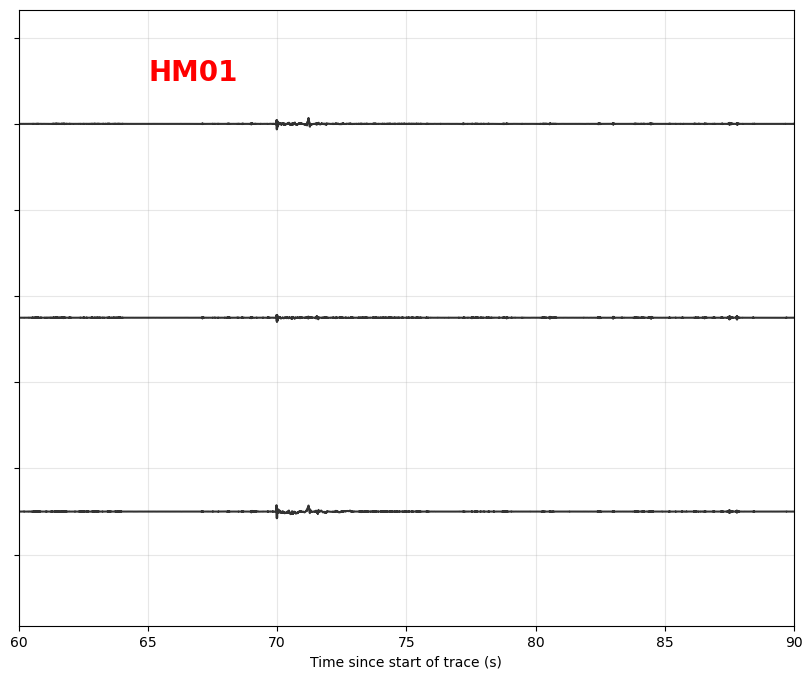

In [443]:
from obspy.geodetics import gps2dist_azimuth


#names = temp['station_name'].to_numpy()
#sta_lats = temp['latitude'].to_numpy()
#sta_lons = temp['longitude'].to_numpy()
channels = ["DHZ", "DHN", "DHE"]

fig, ax = plt.subplots(figsize = (10,8))
distance = []
for i in range(len(st)):
    tr = st[i]
    station = channels[i]
    #dist,baz,az = gps2dist_azimuth(sta_lats[i], sta_lons[i], eq_lat, eq_lon)
    #ypos = (dist/1000)
    ypos = i*-2.25
    #distance.append(ypos)
    ax.plot(tr.times(),ypos+((tr.data/max(tr.data))), color = 'black', alpha = 0.8)
    #ax.text(max(tr.times()),ypos, station,color = 'black', fontweight = 'bold',fontsize = 10, ha='left')
    #ax.text(140,ypos, station,color = 'black', fontweight = 'bold',fontsize = 10, ha='left')
#distance = np.array(distance)
ax.text(65,0.5, "HM01",color = 'red', fontweight = 'bold',fontsize = 20, ha='left')
ax.set_xlabel('Time since start of trace (s)')
#ax.set_ylabel('Distance from earthquake (km)')
ax.tick_params(axis='y', labelleft=False)
#ax.set_xlim(min(tr.times()), max(tr.times()))
ax.set_xlim(60,90) #(60,140)
#ax.set_ylim(min(distance)-0.5, max(distance)+0.5)
ax.grid(alpha = 0.3)
plt.show()


In [423]:
max(tr.data)

312.5